Tavola 8.6  - Abbonamenti alla radio e alla televisione italiana – Anni 1936-2014 

In [1]:
import sqlite3

import pandas as pd
import os
import plotly.express as px
import sqlite3 as db

Qui vengono caricati i path della cartella dedicata ai Datasets e del percorso specifico della serie Istat

In [2]:
df_dir = os.path.join(os.getcwd(), 'Datasets')
df_path = (os.path.join(df_dir, 'Tavola_8.6.xlsx'))

La struttura della tabella non è pulita, dunque si è scelto di saltare le prime cinque righe (contenenti un'intestazione dell'Istat) e la sesta, in quanto quest'ultima è aggregata a quella successiva per la riga di intestazione della tabella. Inoltre saltiamo le ultime righe contenente solo una legenda.

In [3]:
df1 = pd.read_excel(df_path, sheet_name='Tavola 8.6', skiprows=6, skipfooter=5) # sheet_name indica il foglio specifico da cui voglio creare il df dal file
df2 = pd.read_excel(df_path, sheet_name='Tavola 8.6 (segue)', skiprows=6 , skipfooter=6) # il parametro skiprows viene speficicato per dedicere quante righe saltare al file della creazione del df

In [4]:
df1

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Ad uso privato,Speciali (b),Totale,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1936.0,697062.0,NaN,-,-,-,-,-
2,1937.0,825732.0,NaN,-,-,-,-,-
3,1938.0,965577.0,NaN,-,-,-,-,-
4,1939.0,1130540.0,NaN,-,-,-,-,-
5,1940.0,1329723.0,NaN,-,-,-,-,-
6,1941.0,1638317.0,NaN,-,-,-,-,-
7,1942.0,1827950.0,NaN,-,-,-,-,-
8,1943.0,1784246.0,NaN,-,-,-,-,-
9,1944.0,1608247.0,NaN,-,-,-,-,-


In [5]:
df2

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Ad uso privato,Speciali (b),Totale,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1971,1506342,NaN,10559128.0,83834.0,10642962.0,196.800000,65.8
2,1972,1252791,NaN,11186821.0,82103.0,11268924.0,207.200000,70.6
3,1973,1021624,NaN,11720275.0,79932.0,11800207.0,215.500000,72.5
4,1974,824835,NaN,12164423.0,79140.0,12243563.0,222.200000,73.9
5,1975,714891,NaN,12415740.0,74082.0,12489822.0,225.300000,74.0
6,1976,647389,NaN,12677432.0,71134.0,12748566.0,228.800000,74.2
7,1977,611000,NaN,13027633.0,66389.0,13094022.0,234.000000,74.9
8,1978,532800,NaN,13337794.0,77720.0,13415514.0,238.900000,75.7
9,1979,464135,NaN,13637644.0,69894.0,13707538.0,243.400000,76.4


Notiamo che l'aggregazione delle righe sul file excel sta generando confusione per pandas, dunque rinominiamo manualmente l'header della tabella. Inoltre notiamo che la riga 0 è vuota, quindi possiamo eliminarla. La stessa cosa vale per la terza colonna, che è vuota e non rappresenta nulla (su entrambi gli sheet).

In [6]:
columns = [
    "Anno", 
    "Radio (a)",
    "TV - Uso privato", 
    "TV - Speciali (b)", 
    "TV - Totale", 
    "Abbonamenti TV per 1000 abitanti",
    "Abbonamenti TV per 100 famiglie"
]

In [7]:
df1.drop('Unnamed: 2', axis=1, inplace=True) # axis = 1 in questo caso fa in modo di eliminare una colonna, inplace settato a true fa operare sullo stesso df
df2.drop('Unnamed: 2', axis=1, inplace=True) 
df1.drop(0, inplace=True)
df2.drop(0, inplace=True)

df1.columns=columns
df2.columns=columns

Notiamo che una parte degli anni sembra essere un float, quindi specifichiamo il valore a int

In [8]:
df1["Anno"] = df1["Anno"].astype(int)

Concateniamo ora i due dataframe derivanti dai due fogli del file

In [9]:
df = pd.concat([df1, df2], ignore_index=True) # dal momento che l'indice riparte da 0 nel secondo foglio, settiamo ignore_index a true

In [10]:
df

,Anno,Radio (a),TV - Uso privato,TV - Speciali (b),TV - Totale,Abbonamenti TV per 1000 abitanti,Abbonamenti TV per 100 famiglie
0,1936,697062.0,-,-,-,-,-
1,1937,825732.0,-,-,-,-,-
2,1938,965577.0,-,-,-,-,-
3,1939,1130540.0,-,-,-,-,-
4,1940,1329723.0,-,-,-,-,-
...,...,...,...,...,...,...,...
74,2010,….,16654612.0,206512.0,16861124.0,281.374755,66.9
75,2011,….,16706617.0,228347.0,16934964.0,281.423469,66.4
76,2012,….,16813317.0,270396.0,17083713.0,283.080082,66.8
77,2013,….,16809202.0,273423.0,17082625.0,281.630863,65.0


La struttura del df è parzialmente pulita, resta solo da rendere come index la colonna anno e pulire l'anno 2002

In [11]:
df.loc[df["Anno"] == "2002 (c)", "Anno"] = 2002 # il primo è l'indice della riga, il secondo della colonna

In [12]:
df.set_index("Anno", inplace=True)

Analizzando la colonna degli ascolti radio si nota che molti valori sono sporchi (rappresentati con "..."). Per pulire il df, rimpiazziamo questi valori con NaN.

In [13]:
df.replace("….", pd.NA, inplace=True)

Ciononostante la colonna non è ancora numerica, quindi dobbiamo convertirla

In [14]:
df["Radio (a)"] = pd.to_numeric(df["Radio (a)"], errors="coerce")

Ammettiamo di voler lavorare solo sugli ascolti radio (li prendiamo dal 1936 al 1989 in quanto in seguito i dati non sono disponibili)

In [15]:
df_radio = df.loc[(df.index >= 1936) & (df.index <= 1989), ['Radio (a)']].copy()


Nota bene, questo codice invece non avrebbe funzionato in quanto "Anno" è un index

df_radio = df.loc[
    (df["Anno"] >= 1936) & (df["Anno"] <= 1989),  
    ["Anno", "Radio (a)"]
].copy()

Possiamo provare ad interpolare i dati mancanti (dal momento che ce ne sono pochi)

In [16]:
df_radio["Radio (a)"] = df_radio["Radio (a)"].interpolate(method="linear")

<Axes: xlabel='Anno'>

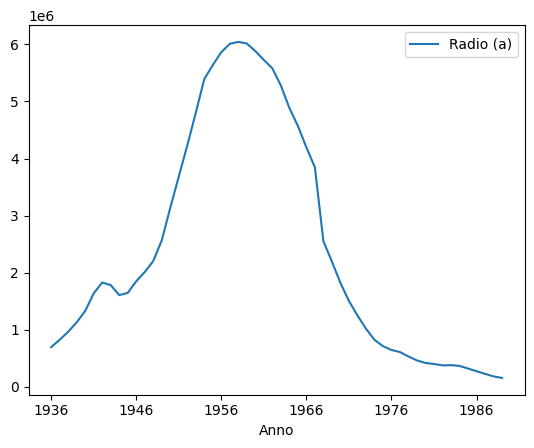

In [17]:
df_radio.plot(kind='line') 

Con plotly express

In [18]:
fig = px.line(df_radio, x=df_radio.index, y="Radio (a)")
fig.show()

Proviamo a creare un database per inserirci i dati dal dataframe. Creiamo inizialmente una cartella Database.

In [19]:
db_path = (os.path.join(os.getcwd(), 'Database'))

Dopodichè creiamo una connessione al database, se non esiste il file (in questo caso 'database.db') viene creato.

In [20]:
conn = db.connect(os.path.join(db_path, 'database.db'))

Creiamo la tabella ascolti_radio sul db, specificandone il name e chiamando il metodo .to_sql sul df

Creiamo il cursore

In [21]:
cursor = conn.cursor()

In [22]:
cursor.execute("DROP TABLE IF EXISTS ascolti_radio")

In [23]:
cursor.execute("""CREATE TABLE IF NOT EXISTS ascolti_radio (
Anno INTEGER PRIMARY KEY,
"Radio (a)" DOUBLE,
"TV - Uso privato" DOUBLE
)""")

In [24]:
df_radio.to_sql(name='ascolti_radio', con=conn, if_exists='append')

54

Eseguiamo la query

In [25]:
cursor.execute("SELECT * FROM ascolti_radio")

Salviamone i risultati nella variabile rows e dopodichè stampiamo i risultati

In [26]:
rows = cursor.fetchall()

In [27]:
for row in rows:
    print(row)

(1936, 697062.0, None)
(1937, 825732.0, None)
(1938, 965577.0, None)
(1939, 1130540.0, None)
(1940, 1329723.0, None)
(1941, 1638317.0, None)
(1942, 1827950.0, None)
(1943, 1784246.0, None)
(1944, 1608247.0, None)
(1945, 1646466.0, None)
(1946, 1850479.0, None)
(1947, 2011454.0, None)
(1948, 2204580.0, None)
(1949, 2566258.0, None)
(1950, 3135195.0, None)
(1951, 3682588.0, None)
(1952, 4227609.0, None)
(1953, 4800170.0, None)
(1954, 5391274.0, None)
(1955, 5636802.0, None)
(1956, 5862226.0, None)
(1957, 6009390.0, None)
(1958, 6041863.0, None)
(1959, 6014238.0, None)
(1960, 5881823.0, None)
(1961, 5726122.0, None)
(1962, 5579574.0, None)
(1963, 5279316.0, None)
(1964, 4886496.0, None)
(1965, 4570501.0, None)
(1966, 4196187.0, None)
(1967, 3844488.0, None)
(1968, 2553413.0, None)
(1969, 2196785.0, None)
(1970, 1822676.0, None)
(1971, 1506342.0, None)
(1972, 1252791.0, None)
(1973, 1021624.0, None)
(1974, 824835.0, None)
(1975, 714891.0, None)
(1976, 647389.0, None)
(1977, 611000.0, None)

Fare riferimento al modulo main per la creazione delle API

Tornando alla dataviz, cerchiamo ora di concatenare (anche se si poteva fare solo un sottodf di quello iniziale) anche gli ascolti TV

Puliamo inizialmente gli ascolti TV privati

In [28]:
df.replace("-", pd.NA, inplace=True)

In [29]:
df["TV - Uso privato"] = pd.to_numeric(df["TV - Uso privato"], errors="coerce")

In [30]:
df_tv_priv = df.loc[(df.index >= 1936) & (df.index <= 1989), ['TV - Uso privato']].copy()

In [31]:
df_tv_priv

,TV - Uso privato
Anno,
1936,NaN
1937,NaN
1938,NaN
1939,NaN
1940,NaN
1941,NaN
1942,NaN
1943,NaN
1944,NaN


Dobbiamo affiancare le colonne, dunque utilizziamo axis=1

In [32]:
df_radio_tv_priv = pd.concat([df_radio, df_tv_priv], axis=1)

In [33]:
df_radio_tv_priv

,Radio (a),TV - Uso privato
Anno,,
1936,6.970620e+05,NaN
1937,8.257320e+05,NaN
1938,9.655770e+05,NaN
1939,1.130540e+06,NaN
1940,1.329723e+06,NaN
1941,1.638317e+06,NaN
1942,1.827950e+06,NaN
1943,1.784246e+06,NaN
1944,1.608247e+06,NaN


Svuotiamo la tabella (nota, non esiste truncate)

In [34]:
cursor.execute("DELETE FROM ascolti_radio")

In [35]:
df_radio_tv_priv.to_sql(name='ascolti_radio', con=conn, if_exists='append')

54

Creiamo ora una nuova figura passando le due serie sull'asse Y

In [37]:
fig2 = px.line(df_radio_tv_priv, x=df_radio_tv_priv.index, y=["Radio (a)", "TV - Uso privato"])
fig2.show()


In [38]:
df_radio_tv_priv.to_csv(os.path.join(os.getcwd(), 'Outputs', 'ascolti_radio_tv_priv.csv'))